In [143]:
import mesa
from functional import seq
import random

from dataclasses import dataclass

In [144]:
from typing import Tuple, Optional, List

# Locations

In [145]:
@dataclass
class Hotel():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0

    # stats
    new_rev: int = 0
    total_rev: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied

In [146]:
@dataclass
class PointOfInterest():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0

    # stats
    visit: int = 0
    total_visit: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied

# Tourist

In [147]:
class Tourist(mesa.Agent):
    def __init__(self, unique_id: int, model, loc: int, trip_length: int):
        super().__init__(unique_id, model)
        self.loc: int = loc
        self.hotel: Optional[Hotel] = None
        self.poi:Optional[PointOfInterest]=None
        self.trip_length: int = trip_length
        self.remaining_life: int = trip_length

        self.satisfaction: int = 0

    def step(self):
        self.remaining_life -=1
        if self.hotel is None and self.remaining_life >= 3:
            hotels = (
                seq(self.model.hotels)
                    .filter(lambda h: h.remaining_capacity() >= 0)
                    .list()
            )

            if len(hotels) <= 0:
                self.remaining_life = -1
                return;

            random.shuffle(hotels)

            self.hotel = hotels[0]
            self.hotel.occupied += 1
            self.hotel.new_rev += 1
            self.hotel.total_rev += 1

            return

        if self.poi is None:
            print("Looking for point of interest")
            no_capacity_poi=[p for p in self.model.poi if p.remaining_capacity()==0]


            if len(no_capacity_poi) > 0:
                print("NO Point of Interest")
                self.satisfaction -= 1
                print(f"self satisfaction: {self.satisfaction}")
                return self.satisfaction
            
            random.shuffle(self.model.poi)
            self.poi = self.model.poi[0]
            
            return
        
            


In [148]:
@dataclass
class ConstantTouristInflow():
    rate: int

    trip_length: int
    
    def new_pops(self) -> int:
        return self.rate
    def new_tourist(self, id, model) -> Tourist:
        return Tourist(id, model, 0, self.trip_length)

In [149]:
import random
@dataclass
class RandomTouristInflow:
    mean_rate: float
    stddev_rate: float

    mean_trip_length: float
    stddev_trip_length: float

    def new_pops(self) -> int:
        # Generate a random number of tourists based on a normal distribution
        return max(0, int(random.gauss(self.mean_rate, self.stddev_rate)))

    def new_tourist(self, id: int, model) -> Tourist:
        # Generate a random trip length based on a normal distribution
        trip_length = max(1, int(random.gauss(self.mean_trip_length, self.stddev_trip_length)))
        return Tourist(id, model, 0, trip_length)

# Model

In [150]:
class Model(mesa.Model):
    def __init__(self, num_tourists, num_hotels, num_of_poi, inflow_model):
        self.hotels: List[Hotel] = []
        self.poi: List[PointOfInterest] = []
        self.tourists: List[Tourist] = []

        self.schedule=mesa.time.RandomActivation(self)

        self.inflow = inflow_model

        # Stats
        
        
        # should be replaced with data from file
        for i in range (num_of_poi):
            self.hotels.append(Hotel(i, 200, 100))

        for i in range (num_hotels):
            self.poi.append(PointOfInterest(i, 200, 100))
            # self.schedule.add(hotel)

        for i in range(num_tourists):
            tourist = Tourist(i, self, 0, 10)
            self.tourists.append(tourist)
            self.schedule.add(tourist)

    def step(self):
        # self.schedule.step()
        # self.schedule.step()
        # self.schedule.step()

        self.update_tourists()
        self.update_tourists()
        self.update_tourists()

        self.remove_tourists()

        print("stats")
        print(self.hotel_stats())

    def update_tourists(self):
        random.shuffle(self.tourists)

        for tourist in self.tourists:
            tourist.step()
        
        for i in range(self.inflow.new_pops()):
            self.tourists.append(self.inflow.new_tourist(i, self))



    def remove_tourists(self):
        # (
        #     seq(self.model.schedule.agents)
        #         .filter()
        # )
        remove_index: list[int] = (seq(self.tourists)
            .enumerate()
            .filter(lambda x: x[1].remaining_life < 0)
            .map(lambda x: x[0])
            .sorted(reverse=True)
            .list()
        )
        for i1 in remove_index:
            if self.tourists[i1].hotel:
                self.tourists[i1].hotel.occupied -=1

            del self.tourists[i1]

    def hotel_stats(self) -> Tuple[float, float, float]:
        total_capacity: int = (seq(self.hotels)
            .map(lambda h: h.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )
        empty_rooms: int = (seq(self.hotels)
            .map(lambda h: h.remaining_capacity())
            .fold_left(0, lambda acc, next: acc + next)
        )
        occupied_rooms: int = (seq(self.hotels)
            .map(lambda h: h.occupied)
            .fold_left(0, lambda acc, next: acc + next)
        )
        
        new_reservations: int = (seq(self.hotels)
            .map(lambda h: h.new_rev)
            .fold_left(0, lambda acc, next: acc + next)
        )
        for hotel in self.hotels:
            hotel.new_rev = 0

        return (total_capacity, empty_rooms, occupied_rooms, new_reservations)

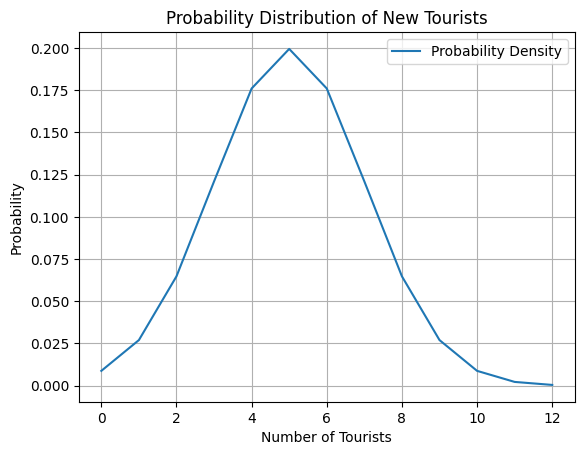

In [151]:
import matplotlib.pyplot as plt
import numpy as np

mean_rate=5
stddev_rate=2

x = np.arange(0, mean_rate + 4 * stddev_rate, 1)
y = (1 / (stddev_rate * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_rate) / stddev_rate) ** 2)
plt.plot(x, y, label="Probability Density")
plt.title("Probability Distribution of New Tourists")
plt.xlabel("Number of Tourists")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()

In [152]:
starter_model=Model(3, 3, 3, RandomTouristInflow(mean_rate=5, stddev_rate=2, mean_trip_length=10, stddev_trip_length=3))
for i in range(360):
    starter_model.step()

stats
(300, 292, 8, 8)
stats
(300, 277, 23, 15)
stats
(300, 258, 42, 22)
stats
(300, 252, 48, 15)
stats
(300, 253, 47, 11)
stats
(300, 255, 45, 7)
stats
(300, 259, 41, 15)
stats
(300, 255, 45, 15)
stats
(300, 256, 44, 14)
stats
(300, 255, 45, 18)
stats
(300, 260, 40, 10)
stats
(300, 256, 44, 15)
stats
(300, 257, 43, 15)
stats
(300, 261, 39, 10)
stats
(300, 257, 43, 14)
stats
(300, 261, 39, 11)
stats
(300, 265, 35, 13)
stats
(300, 259, 41, 16)
stats
(300, 256, 44, 14)
stats
(300, 257, 43, 15)
stats
(300, 257, 43, 13)
stats
(300, 250, 50, 18)
stats
(300, 253, 47, 10)
stats
(300, 255, 45, 19)
stats
(300, 256, 44, 15)
stats
(300, 254, 46, 15)
stats
(300, 251, 49, 14)
stats
(300, 250, 50, 11)
stats
(300, 250, 50, 20)
stats
(300, 258, 42, 10)
stats
(300, 256, 44, 10)
stats
(300, 249, 51, 22)
stats
(300, 254, 46, 12)
stats
(300, 259, 41, 9)
stats
(300, 261, 39, 16)
stats
(300, 268, 32, 8)
stats
(300, 265, 35, 14)
stats
(300, 256, 44, 16)
stats
(300, 258, 42, 8)
stats
(300, 256, 44, 11)
stats
